<a href="https://colab.research.google.com/github/Luciferiitbombay/SOC.DeNoise/blob/main/Segan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input
import numpy as np
import IPython.display
import glob
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt
import urllib.request

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Extracting Data

In [ ]:
!mkdir "CleanData"
!mkdir "NoisyData"

!unzip "/content/drive/My Drive/clean_trainset_wav.zip" -d "CleanData"
!unzip "/content/drive/My Drive/noisy_trainset_wav.zip" -d "NoisyData"

Streaming output truncated to the last 5000 lines.
  inflating: NoisyData/p267_421.wav  
  inflating: NoisyData/p268_001.wav  
  inflating: NoisyData/p268_002.wav  
  inflating: NoisyData/p268_003.wav  
  inflating: NoisyData/p268_004.wav  
  inflating: NoisyData/p268_005.wav  
  inflating: NoisyData/p268_006.wav  
  inflating: NoisyData/p268_007.wav  
  inflating: NoisyData/p268_009.wav  
  inflating: NoisyData/p268_010.wav  
  inflating: NoisyData/p268_011.wav  
  inflating: NoisyData/p268_012.wav  
  inflating: NoisyData/p268_013.wav  
  inflating: NoisyData/p268_014.wav  
  inflating: NoisyData/p268_015.wav  
  inflating: NoisyData/p268_016.wav  
  inflating: NoisyData/p268_017.wav  
  inflating: NoisyData/p268_018.wav  
  inflating: NoisyData/p268_019.wav  
  inflating: NoisyData/p268_020.wav  
  inflating: NoisyData/p268_021.wav  
  inflating: NoisyData/p268_022.wav  
  inflating: NoisyData/p268_024.wav  
  inflating: NoisyData/p268_025.wav  
  inflating: NoisyData/p268_026.wav  

#Load the Data

In [ ]:
clean_sounds = glob.glob('/content/CleanData/*')
noisy_sounds = glob.glob('/content/NoisyData/*')

clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for i in tqdm(clean_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  clean_sounds_list = tf.concat((clean_sounds_list,so),0)

noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for i in tqdm(noisy_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

clean_sounds_list.shape,noisy_sounds_list.shape

  0%|          | 0/11571 [00:00<?, ?it/s]

  0%|          | 0/11571 [00:00<?, ?it/s]

(TensorShape([540938091, 1]), TensorShape([540938091, 1]))

In [ ]:
batching_size = 12000

clean_train,noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]//2-batching_size,batching_size)):
  clean_train.append(clean_sounds_list[i:i+batching_size])
  noisy_train.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

clean_train.shape,noisy_train.shape

  0%|          | 0/22539 [00:00<?, ?it/s]

(TensorShape([22539, 12000, 1]), TensorShape([22539, 12000, 1]))

# Create a tf.data.Dataset

In [ ]:
def get_dataset(x_train,y_train):
  dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
  dataset = dataset.shuffle(100).batch(64,drop_remainder=True)
  return dataset

In [ ]:
train_dataset = get_dataset(noisy_train[:20000],clean_train[:20000])
test_dataset = get_dataset(noisy_train[20000:],clean_train[20000:])

#Reviewing Sample Waveform

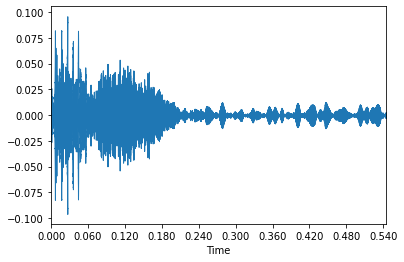

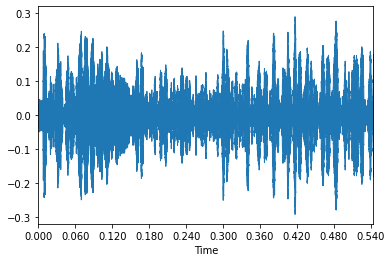

In [ ]:
librosa.display.waveplot(np.squeeze(clean_train[5].numpy(),axis=-1))
plt.show()
librosa.display.waveplot(np.squeeze(noisy_train[5].numpy(),axis=-1))
plt.show()

#Creating the Model

In [ ]:
inp = Input(shape=(batching_size,1))

c1 = Conv1D(2,32,2,'same',activation='relu')(inp)
c2 = Conv1D(4,32,2,'same',activation='relu')(c1)
c3 = Conv1D(8,32,2,'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(32,32,2,'same',activation='relu')(c4)

dc1 = Conv1DTranspose(32,32,1,padding='same')(c5)
conc = Concatenate()([c5,dc1])
dc2 = Conv1DTranspose(16,32,2,padding='same')(conc)
conc = Concatenate()([c4,dc2])
dc3 = Conv1DTranspose(8,32,2,padding='same')(conc)
conc = Concatenate()([c3,dc3])
dc4 = Conv1DTranspose(4,32,2,padding='same')(conc)
conc = Concatenate()([c2,dc4])
dc5 = Conv1DTranspose(2,32,2,padding='same')(conc)
conc = Concatenate()([c1,dc5])
dc6 = Conv1DTranspose(1,32,2,padding='same')(conc)
conc = Concatenate()([inp,dc6])
dc7 = Conv1DTranspose(1,32,1,padding='same',activation='linear')(conc)
generator = tf.keras.models.Model(inp,dc7)

generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6000, 2)      66          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 3000, 4)      260         ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1500, 8)      1032        ['conv1d_1[0][0]']               
                                                                                              

In [ ]:
inp = Input(shape=(batching_size,1))
tar = Input(shape=(batching_size,1))
c1 = Conv1D(2,32,2,'same',activation='relu')(inp)
c2 = Conv1D(4,32,2,'same',activation='relu')(c1)
c3 = Conv1D(8,32,2,'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(16,32,2,'same',activation='relu')(c4)
c6 = Conv1D(16,32,2,'same',activation='relu')(c5)
c7 = Conv1D(16,32,2,'same',activation='relu')(c6)
c8 = Conv1D(16,32,2,'same',activation='relu')(c7)
c9 = Conv1D(1,32,2,'same',activation='relu')(c8)

discriminator = tf.keras.models.Model([inp,tar],c9)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 12000, 1)]   0           []                               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 6000, 2)      66          ['input_2[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 3000, 4)      260         ['conv1d_5[0][0]']               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 1500, 8)      1032        ['conv1d_6[0][0]']               
                                                                                            

#Training

In [ ]:
import tensorflow as tf
import os
import time
import datetime
import matplotlib.pyplot as plt

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100
epochs = 100

def generated_audio(model,test_input,tar):

    prediction = model(test_input,training = True)
    mse = 0
    for i in range(prediction.shape[0]):
      mse = mse + tf.reduce_mean(tf.abs(tar[i] - prediction[i]))
    mse = mse/prediction.shape[0]
    return mse

def gen_loss(disc_generated_output,gen_output,target):

    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA*l1_loss)

    return total_gen_loss,gan_loss,l1_loss

def  discriminator_loss(disc_real_output,disc_generated_output):

    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    toal_disc_loss = real_loss + generated_loss

    return toal_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dirs = './SEGAN_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dirs,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, discriminator_optimizer = discriminator_optimizer, generator = generator, discriminator = discriminator)

log_dir = "SEGAN_logs"

summary_writer = tf.summary.create_file_writer(log_dir + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

@tf.function

def train_step(input_audio, target, epoch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_output = generator(input_audio, training = True)

        disc_real_output = discriminator([input_audio,target], training = True)
        disc_generated_output = discriminator([input_audio,gen_output], training = True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = gen_loss(disc_generated_output,gen_output,target)

        disc_loss = discriminator_loss(disc_real_output,disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients((zip(discriminator_gradients,discriminator.trainable_variables)))

    with summary_writer.as_default():

        tf.summary.scalar('gen_total_loss',gen_total_loss, epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss,step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    print("finished")

def fit(epochs,test_ds):

    for epoch in range(epochs):

        start = time.time()

        mse = 0
        for example_input, example_target in test_ds.take(78):
            mse = mse + generated_audio(generator,example_input, example_target)

        print("Epoch {} mse {}".format(epoch, mse/78))
        
        for n, (input_audio,target) in train_dataset.enumerate():
            if (n+1)%100 == 0:
                print(n)
            train_step(input_audio, target,epoch)
        print()

        if (epoch + 1)%5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print("Time taken for epoch {} is {} sec \n".format(epoch+1, time.time()-start))

    checkpoint.save(file_prefix=checkpoint_prefix)

#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dirs))

fit(epochs, test_dataset)

Epoch 0 mse 0.03588682413101196
finished
finished
tf.Tensor(99, shape=(), dtype=int64)
tf.Tensor(199, shape=(), dtype=int64)
tf.Tensor(299, shape=(), dtype=int64)

Time taken for epoch 1 is 36.235734701156616 sec 

Epoch 1 mse 0.011148122139275074
finished
tf.Tensor(99, shape=(), dtype=int64)
tf.Tensor(199, shape=(), dtype=int64)
tf.Tensor(299, shape=(), dtype=int64)

Time taken for epoch 2 is 21.503072500228882 sec 

Epoch 2 mse 0.009856417775154114
finished
tf.Tensor(99, shape=(), dtype=int64)
tf.Tensor(199, shape=(), dtype=int64)
tf.Tensor(299, shape=(), dtype=int64)

Time taken for epoch 3 is 21.749308586120605 sec 

Epoch 3 mse 0.009252490475773811
finished
tf.Tensor(99, shape=(), dtype=int64)
tf.Tensor(199, shape=(), dtype=int64)
tf.Tensor(299, shape=(), dtype=int64)

Time taken for epoch 4 is 24.01766800880432 sec 

Epoch 4 mse 0.008877112530171871
finished
tf.Tensor(99, shape=(), dtype=int64)
tf.Tensor(199, shape=(), dtype=int64)
tf.Tensor(299, shape=(), dtype=int64)

Time take

#Testing Samples

In [ ]:
from IPython.display import Audio
Audio(np.squeeze(noisy_train[22].numpy()),rate=16000)

In [ ]:
Audio(tf.squeeze(generator.predict(tf.expand_dims(tf.expand_dims(noisy_train[22],-1),0))),rate=16000)

In [ ]:
generator.save('/content/drive/MyDrive/SEGANModel.h5')

# Inference

Handling different sized audio inputs can be solved by overlapping prediction frames and removing the intersection part from the final waveform

In [ ]:
def get_audio(path):
  audio,_ = tf.audio.decode_wav(tf.io.read_file(path),1)
  return audio

In [ ]:
def inference_preprocess(path):
  audio = get_audio(path)
  audio_len = audio.shape[0]
  batches = []
  for i in range(0,audio_len-batching_size,batching_size):
    batches.append(audio[i:i+batching_size])

  batches.append(audio[-batching_size:])
  diff = audio_len - (i + batching_size)
  return tf.stack(batches), diff

In [ ]:
def predict(path):
  test_data,diff = inference_preprocess(path)
  predictions = generator.predict(test_data)
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((final_op,predictions[-1][-diff:]),axis=0)
  return final_op

In [ ]:
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=16000)

In [ ]:
Audio(tf.squeeze(predict(noisy_sounds[4])),rate=16000)

In [ ]:
%%timeit
tf.squeeze(predict(noisy_sounds[3]))

10 loops, best of 5: 41.3 ms per loop


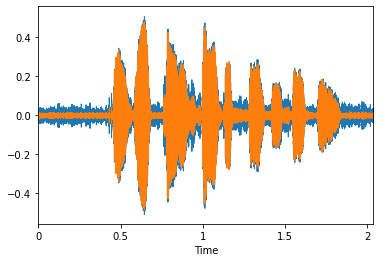

In [ ]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1))
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[4])))

#Quantization and TFLite Conversion

In [ ]:
lite_model = tf.lite.TFLiteConverter.from_keras_model(generator)
lite_model.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = lite_model.convert()

INFO:tensorflow:Assets written to: /tmp/tmpvxxsqa1a/assets


In [ ]:
with open('/content/drive/MyDrive/TFLiteGenerator.tflite','wb') as f:
  f.write(tflite_model_quant)

#TFLite Inference

In [ ]:
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/TFLiteGenerator.tflite')
interpreter.allocate_tensors()

In [ ]:
def predict_tflite(path):
  test_audio,diff = inference_preprocess(path)
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  preds = []
  for i in test_audio:
    interpreter.set_tensor(input_index, tf.expand_dims(i,0))
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    preds.append(predictions)

  predictions = tf.squeeze(tf.stack(preds,axis=1))
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((tf.squeeze(final_op),predictions[-1][-diff:]),axis=0)
  return final_op

In [ ]:
# Original Noisy Audio
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=16000)

In [ ]:
# Clean Audio
Audio(np.squeeze(get_audio(clean_sounds[4]).numpy(),-1),rate=16000)

In [ ]:
# Output Audio
Audio(predict_tflite(noisy_sounds[4]),rate=16000)

In [ ]:
%%timeit
predict_tflite(noisy_sounds[3])

10 loops, best of 5: 164 ms per loop


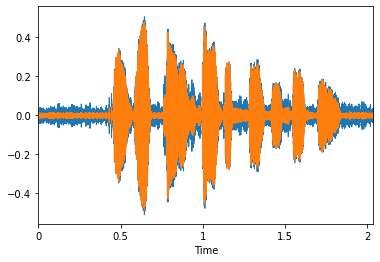

In [ ]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1))
librosa.display.waveplot(predict_tflite(noisy_sounds[4]).numpy())